#### **EJERCICIO 4 - Agrupamiento (Clustering)**

#Integrantes:
- Blas Chuc - 110253
- Franco Rodriguez - 108799
- Helen Elizabeth Chen - 110195
- Tomas Caporaletti - 108598
- Lorenzo Busato - 110490



> En este punto se busca analizar si es posible agrupar los datos en función de algún criterio.
Vamos a utilizar un conjunto de datos que contiene información sobre algunos tracks
(canciones) de Spotify.

Para esta tarea se propone utilizar el algoritmo K-Means.

---





### Importamos librerías

In [40]:
# Para manejo de datos
import pandas as pd
import numpy as np

# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Descarga de modelos
from joblib import dump

# Librerías de modelos
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from yellowbrick.cluster import SilhouetteVisualizer

# Otras
import os
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Carga del dataset

In [41]:
!gdown --id 1i1hyfG4DIgv1r3mVqaJHLMEwyJvnxgAZ

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1i1hyfG4DIgv1r3mVqaJHLMEwyJvnxgAZ
To: /content/playlist_spotify.csv
100% 54.4k/54.4k [00:00<00:00, 57.3MB/s]


In [42]:
ds_original = pd.read_csv('playlist_spotify.csv')

# Dataset de trabajo:
ds = ds_original.copy()

### Análisis del Dataset

Antes de empezar, es fundamental analizar y preparar los datos.

In [43]:
ds

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.713000,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143
1,0.192000,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582
2,0.333000,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199
3,0.601000,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798
4,0.883000,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.000175,0.374,333827,0.943,0.000156,6,0.1250,-4.108,0,0.0556,112.084,4,0.338
746,0.001970,0.487,213000,0.867,0.006020,10,0.0968,-3.293,0,0.0543,160.048,4,0.403
747,0.916000,0.605,125867,0.314,0.000000,0,0.3590,-7.631,1,0.0327,138.148,4,0.836
748,0.168000,0.700,249493,0.823,0.000028,3,0.1220,-6.892,1,0.0373,144.060,4,0.745


In [44]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      750 non-null    float64
 1   danceability      750 non-null    float64
 2   duration          750 non-null    int64  
 3   energy            750 non-null    float64
 4   instrumentalness  750 non-null    float64
 5   key               750 non-null    int64  
 6   liveness          750 non-null    float64
 7   loudness          750 non-null    float64
 8   mode              750 non-null    int64  
 9   speechiness       750 non-null    float64
 10  tempo             750 non-null    float64
 11  time_signature    750 non-null    int64  
 12  valence           750 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 76.3 KB


Descripción de los campos:

| Variable | Descripción |
| :--- | :--- |
| **acousticness** | Una medida de confianza entre 0.0 y 1.0 sobre si la pista es acústica. Un valor de 1.0 representa una alta confianza en que la pista es acústica. |
| **danceability** | Describe qué tan adecuada es una pista para bailar, basándose en una combinación de elementos musicales como el tempo, la estabilidad del ritmo, la fuerza del compás y la regularidad general. |
| **duration** | La duración de la pista en milisegundos. |
| **energy** | Es una medida perceptual de intensidad y actividad que va de 0.0 a 1.0. Típicamente, las pistas enérgicas se sienten rápidas, fuertes y ruidosas. |
| **instrumentalness**| Predice si una pista no contiene vocales. Cuanto más se acerca el valor a 1.0, mayor es la probabilidad de que la pista no tenga contenido vocal. |
| **key** | La tonalidad en la que se encuentra la pista. (E.g., 0 = Do, 1 = Do♯/Re♭, 2 = Re). |
| **liveness** | Detecta la presencia de una audiencia en la grabación, indicando si la pista fue grabada en vivo. |
| **loudness** | La sonoridad general de una pista medida en decibelios (dB). |
| **mode** | Indica si la melodía de la pista es mayor (1) o menor (0). |
| **speechiness** | Detecta la presencia de palabras habladas en una pista. Alto (> 0.66): Es principalmente hablado (como un podcast). Medio (0.33 - 0.66): Es una mezcla de música y voz (como el rap). Bajo (< 0.33): Es principalmente música. |
| **tempo** | La velocidad o el ritmo de la pista en pulsos por minuto (BPM). |
| **time_signature** | El compás de la pista, que especifica cuántos pulsos hay en cada medida. |
| **valence** | Describe la positividad musical transmitida por una pista (alegre vs. triste). |





#### Clasificación y Análisis de variables

**Cuantitativas Continuas**: asociadas al proceso de medir; pueden tomar infinitos valores intermedios.
| Variable | Justificación |
| :--- | :--- |
| acousticness | Es una medida de probabilidad en una escala de 0 a 1. |
| danceability | Describe la aptitud para el baile en una escala continua de 0 a 1. |
| duration | Representa el tiempo, una magnitud continua. |
| energy | Mide la intensidad en una escala continua de 0 a 1. |
| instrumentalness| Mide la probabilidad (0 a 1) de ausencia de vocales. |
| liveness | Mide la probabilidad (0 a 1) de que la pista sea en vivo. |
| loudness | La sonoridad en decibelios (dB) es una escala de medición continua. |
| speechiness | Mide la proporción de palabras habladas en una escala continua. |
| tempo | La velocidad en BPM puede tener valores decimales. |
| valence | Mide la positividad musical en una escala continua de 0 a 1. |

**Cuantitativas Discretas**: asociadas al proceso de contar; no existen valores intermedios.
| Variable | Justificación |
| :--- | :--- |
| time_signature| Es un conteo del número de pulsos por compás (valores enteros). |

**Cualitativas Ordinales (Cuasicuantitativas)**: las categorías tienen un orden, pero no se puede medir la distancia entre ellas.
| Variable | Justificación |
| :--- | :--- |
| key | Representa notas musicales con un orden, pero sin una distancia uniforme. |

**Cualitativas Nominales**: etiquetas distintas sin un ordenamiento lógico entre ellas.
| Variable | Justificación |
| :--- | :--- |
| mode | Son dos categorías (1: Mayor/0: Menor) sin un orden intrínseco. |

##### **Variables Cuantitativas - Medidas de Resumen:**

In [45]:
# Variables cuantitativas
cuantitativas_continuas = ['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
                           'tempo', 'valence']

cuantitativas_discretas = ['time_signature']

cuantitativas = cuantitativas_continuas + cuantitativas_discretas

cuantitativas_ds = ds[cuantitativas]

# Medidas de resumen
cuantitativas_resumen = cuantitativas_ds.describe().T

# Calculamos la moda
modas = cuantitativas_ds.mode().iloc[0]

# Calculamos el rango
cuantitativas_resumen['rango'] = cuantitativas_resumen['max'] - cuantitativas_resumen['min']


cuantitativas_resumen = cuantitativas_resumen.rename(columns={
    'mean': 'media',
    '50%': 'mediana',
    '25%': 'primer_cuartil (25%)',
    '75%': 'tercer_cuartil (75%)'
})

cuantitativas_resumen['moda'] = modas

cuantitativas_resumen = cuantitativas_resumen[[
    'media', 'mediana', 'moda', 'primer_cuartil (25%)', 'tercer_cuartil (75%)', 'rango'
]]

display(cuantitativas_resumen)


,media,mediana,moda,primer_cuartil (25%),tercer_cuartil (75%),rango
acousticness,0.357394,0.24450,0.9920,0.03715,0.678500,0.993999
danceability,0.596439,0.60600,0.5250,0.48000,0.715750,0.879000
duration,220112.733333,215108.50000,213440.0000,185490.25000,244236.750000,641520.000000
energy,0.594188,0.63150,0.6660,0.42325,0.804750,0.985750
instrumentalness,0.100245,0.00001,0.0000,0.00000,0.002245,0.967000
liveness,0.203376,0.12900,0.1020,0.09455,0.264750,0.955000
loudness,-8.509339,-7.27000,-7.2730,-10.17350,-5.097750,29.068000
speechiness,0.098966,0.04875,0.0349,0.03590,0.113000,0.697600
tempo,120.405761,120.10450,89.0190,98.99800,138.074750,148.415000
valence,0.497321,0.48300,0.1990,0.29700,0.684500,0.941800


##### **Variables cualitativas - sus distintos valores existentes y cantidad de filas**

In [46]:
cualitativas = ['mode', 'key']

resumenes_cualitativos = {}

for variable in cualitativas:
    print(f"{variable}")

    conteo_valores = ds[variable].value_counts()

    df_resumen = conteo_valores.reset_index()

    df_resumen.columns = ['Valores unicos', 'Filas']

    resumenes_cualitativos[variable] = df_resumen

    display(df_resumen.T)

    print("\n")

mode


,0,1
Valores unicos,1,0
Filas,556,194




key


,0,1,2,3,4,5,6,7,8,9,10,11
Valores unicos,0,2,1,9,5,7,8,4,10,11,6,3
Filas,113,92,85,74,69,63,51,48,48,46,44,17


#### Datos faltantes

In [47]:
faltantes = ds.isnull().sum()
display(faltantes.to_frame().T)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0,0,0,0,0,0,0,0,0,0,0,0,0


No hay datos faltantes en el dataset. Por lo tanto, no es necesario imputar o eliminar datos.

#### Outliers (Valores Atípicos)

Para detectar nuestros outliers, realizaremos Box-Plots para todas las Variables Cuantitativas.

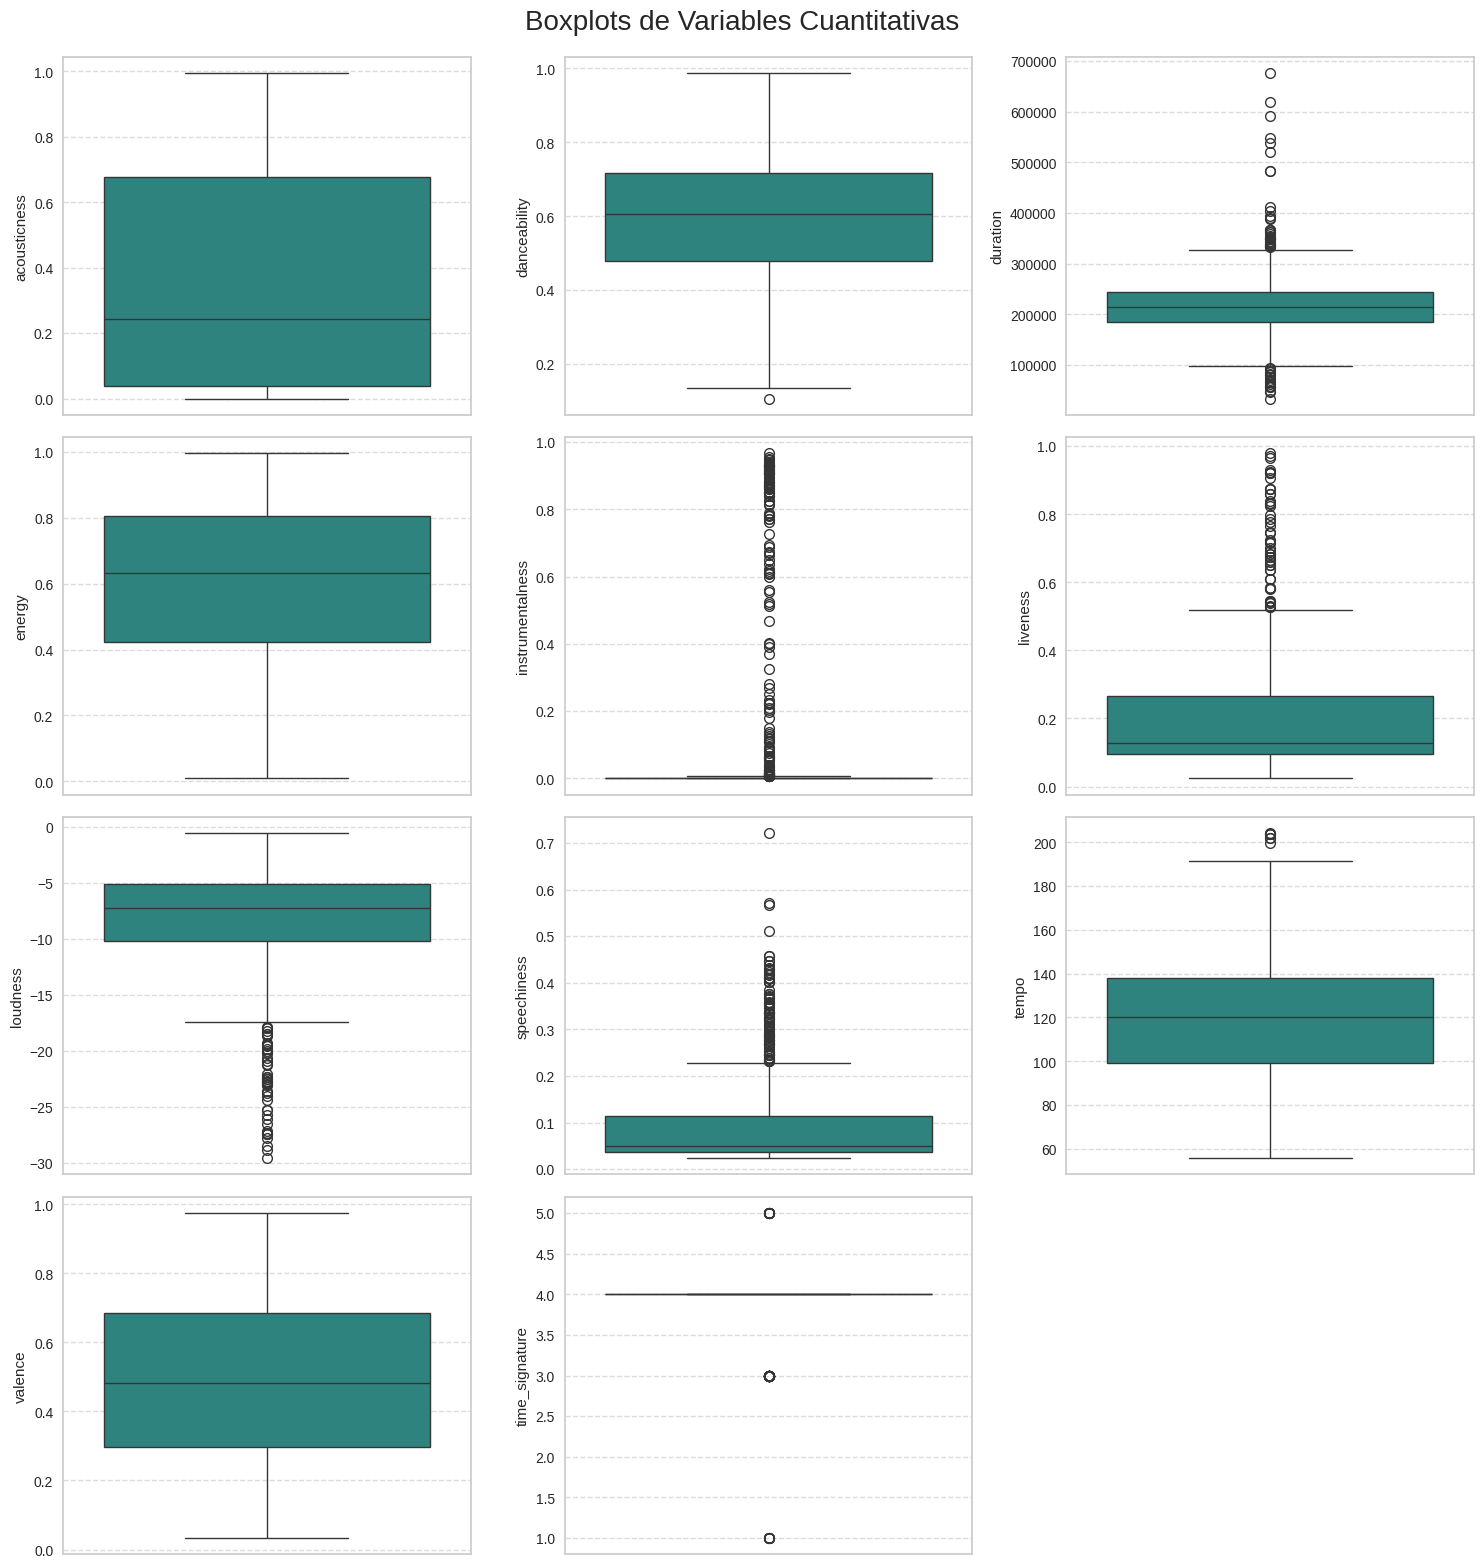

In [48]:
cols = 3
filas = -(-len(cuantitativas) // cols)

fig, axes = plt.subplots(filas, cols, figsize=(cols * 5, filas * 4))
axes = axes.flatten()

# boxplot para cada variable
for i, variable in enumerate(cuantitativas):
    sns.boxplot(data=ds, y=variable, ax=axes[i], palette='viridis')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)


for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Boxplots de Variables Cuantitativas', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

También, identificaremos los outliers según su puntuación de z-score modificado:

In [49]:
def z_mod_calculation(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))

  if MAD == 0:
    return pd.Series(0, index=serie.index)

  return (serie - median) * 0.6745 / MAD

for columna in cuantitativas:
    mod_z_scores = z_mod_calculation(ds[columna])

    # Encontramos las filas que superan el umbral
    outliers_df = ds[mod_z_scores.abs() > 3.5]


    if not outliers_df.empty:
        print(f"\n▼ Outliers encontrados en la variable '{columna}' ({len(outliers_df)} filas):")
        display(outliers_df[[columna]].head()) # Muestra el valor de la columna outlier

    else:
        print(f"\n- No se encontraron outliers en '{columna}'.")


- No se encontraron outliers en 'acousticness'.

- No se encontraron outliers en 'danceability'.

▼ Outliers encontrados en la variable 'duration' (20 filas):


,duration
47,403280
68,520661
173,547880
197,592000
215,46107



- No se encontraron outliers en 'energy'.

▼ Outliers encontrados en la variable 'instrumentalness' (296 filas):


,instrumentalness
0,0.816000
3,0.210000
4,0.000173
7,0.609000
8,0.839000



▼ Outliers encontrados en la variable 'liveness' (74 filas):


,liveness
30,0.666
36,0.441
60,0.436
68,0.979
73,0.440



▼ Outliers encontrados en la variable 'loudness' (36 filas):


,loudness
18,-23.072
25,-25.257
32,-22.533
35,-27.385
47,-27.127



▼ Outliers encontrados en la variable 'speechiness' (163 filas):


,speechiness
10,0.296
19,0.416
21,0.357
22,0.335
23,0.336



- No se encontraron outliers en 'tempo'.

- No se encontraron outliers en 'valence'.

- No se encontraron outliers en 'time_signature'.


  Tras analizar los boxplots y el Z-score modificado, decidimos conservar todos los outliers identificados. Esta decisión se basa en que dichos valores no representan errores en los datos, sino que reflejan casos extremos válidos dada la diversidad del espectro musical.

*   `instrumentalness`, `liveness`, `speechiness`: sus outliers representan categorías de audio minoritarias pero igualmente válidas, que difieren de la norma.

*   `duration`: sus outliers reflejan estructuras de canciones no estándar, como pistas muy largas o muy cortas, en contraste con el formato de radio de 3-4 minutos.

* `loudness`, `energy`, `tempo`: sus outliers son producto de la diversidad de géneros musicales, abarcando desde estilos suaves y lentos hasta géneros rápidos y fuertes.

* `time_signature`: sus outliers simplemente indican compases musicales menos comunes pero correctos (como 3/4 o 5/4), que son una característica de ciertos géneros frente al omnipresente 4/4.

### a) Analizamos la tendencia al clustering del dataset





Para este ejercicio, utilizaremos el estadístico de Hopkins. Este nos va a permitir determinar si nuestro conjunto de datos presenta una estructura de clústeres.

In [50]:
def hopkins_statistic(datos):
    n, d = datos.shape
    m = int(0.1 * n)

    nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(datos)
    rand_indices = random.sample(range(n), m)

    u_distances = []
    w_distances = []

    for i in range(m):
        random_point = np.random.uniform(np.min(datos, axis=0), np.max(datos, axis=0), d).reshape(1, -1)
        u_dist, _ = nbrs.kneighbors(random_point, return_distance=True)
        u_distances.append(u_dist[0][0])

        w_dist, _ = nbrs.kneighbors(datos[rand_indices[i]].reshape(1, -1), return_distance=True)
        w_distances.append(w_dist[0][1])

    # Calculamos el estadístico
    H = sum(u_distances) / (sum(u_distances) + sum(w_distances))
    return H

In [51]:
# Escalamos los datos y ejecutamos el estadístico de Hopkins

cuantitativas = ['acousticness', 'danceability', 'duration', 'energy', 'instrumentalness',
                 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'time_signature']

datos_cuantitativos = ds[cuantitativas]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(datos_cuantitativos)
scaled_df = pd.DataFrame(data_scaled, columns=cuantitativas)
scaled_df.to_csv('datos_escalados.csv', index=False)

In [52]:
# Ejecuto hopkins

hopkins_score = hopkins_statistic(data_scaled)

print(f"Estadístico de Hopkins: {hopkins_score:.4f}")

if hopkins_score > 0.75:
    print("✅ Como es mayor a 0.75, el dataset muestra una fuerte tendencia al clustering.")
elif hopkins_score > 0.5:
    print("🤔 Como es cercano a 0.5, El dataset muestra una tendencia moderada al clustering.")
else:
    print("⚠️ Como es menor a 0.5, El dataset tiene una baja tendencia al clustering (distribución aleatoria).")

Estadístico de Hopkins: 0.7676
✅ Como es mayor a 0.75, el dataset muestra una fuerte tendencia al clustering.


### b) Estimar la cantidad apropiada de grupos que se deben formar.

Para estimar la cantidad apropiada de grupos (K) para separar nuestro dataset, utilizaremos el Método del Codo:

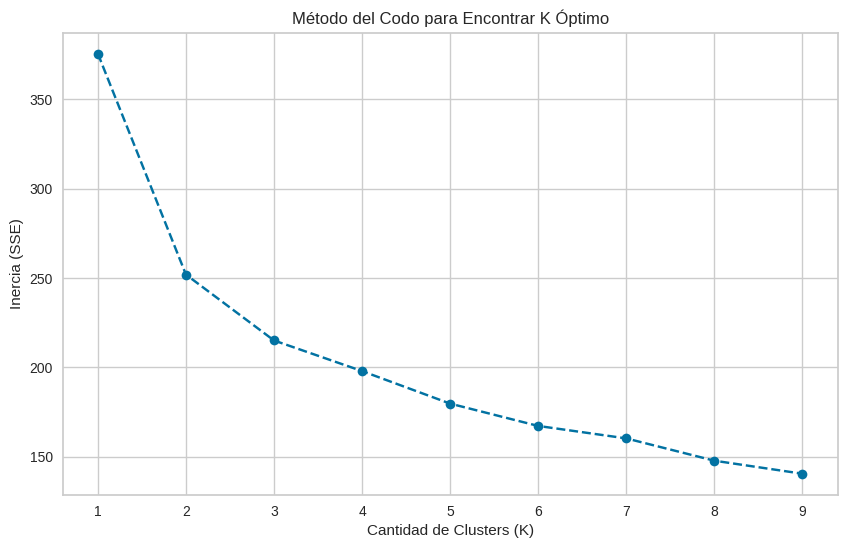

In [53]:
inercia = []
rango_k = range(1, 10)
for k in rango_k:

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)

    kmeans.fit(data_scaled)

    inercia.append(kmeans.inertia_)


# Grafico
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercia, marker='o', linestyle='--', color='b')
plt.xlabel('Cantidad de Clusters (K)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xticks(rango_k)
plt.grid(True)
plt.show()

Observando el gráfico, vemos que el codo se encuentra cuando K = 2. Esto significa que 2 es número óptimo de clústeres según este método.

### c) Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.

El Índice de Silhouette es una métrica que nos permite evaluar la calidad de un clustering al medir qué tan bien se separan los grupos entre sí.

Es por esto que realizaremos un **análisis de Silhouette** para comparar su resultado con el que nos dio previamente el método del Codo:


El K óptimo según el Análisis de Silueta es: 2


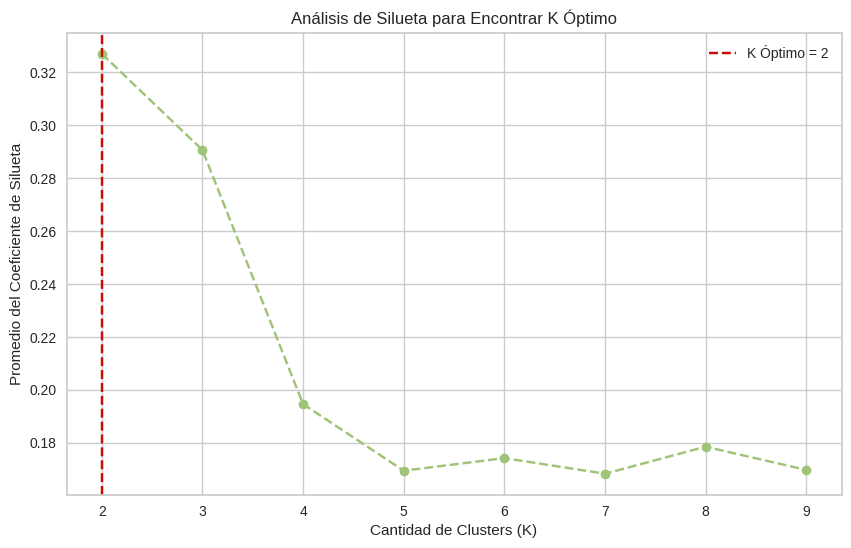

In [54]:
silhouette_scores = []
rango_k = range(2, 10)

for k in rango_k:

    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(data_scaled)

    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# K con el score más alto
k_optimo_silueta = rango_k[silhouette_scores.index(max(silhouette_scores))]
print(f"\nEl K óptimo según el Análisis de Silueta es: {k_optimo_silueta}")

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(rango_k, silhouette_scores, marker='o', linestyle='--', color='g')

# Resaltamos el K óptimo
plt.axvline(x=k_optimo_silueta, color='r', linestyle='--', label=f'K Óptimo = {k_optimo_silueta}')

plt.xlabel('Cantidad de Clusters (K)')
plt.ylabel('Promedio del Coeficiente de Silueta')
plt.title('Análisis de Silueta para Encontrar K Óptimo')
plt.xticks(rango_k)
plt.legend()
plt.grid(True)
plt.show()

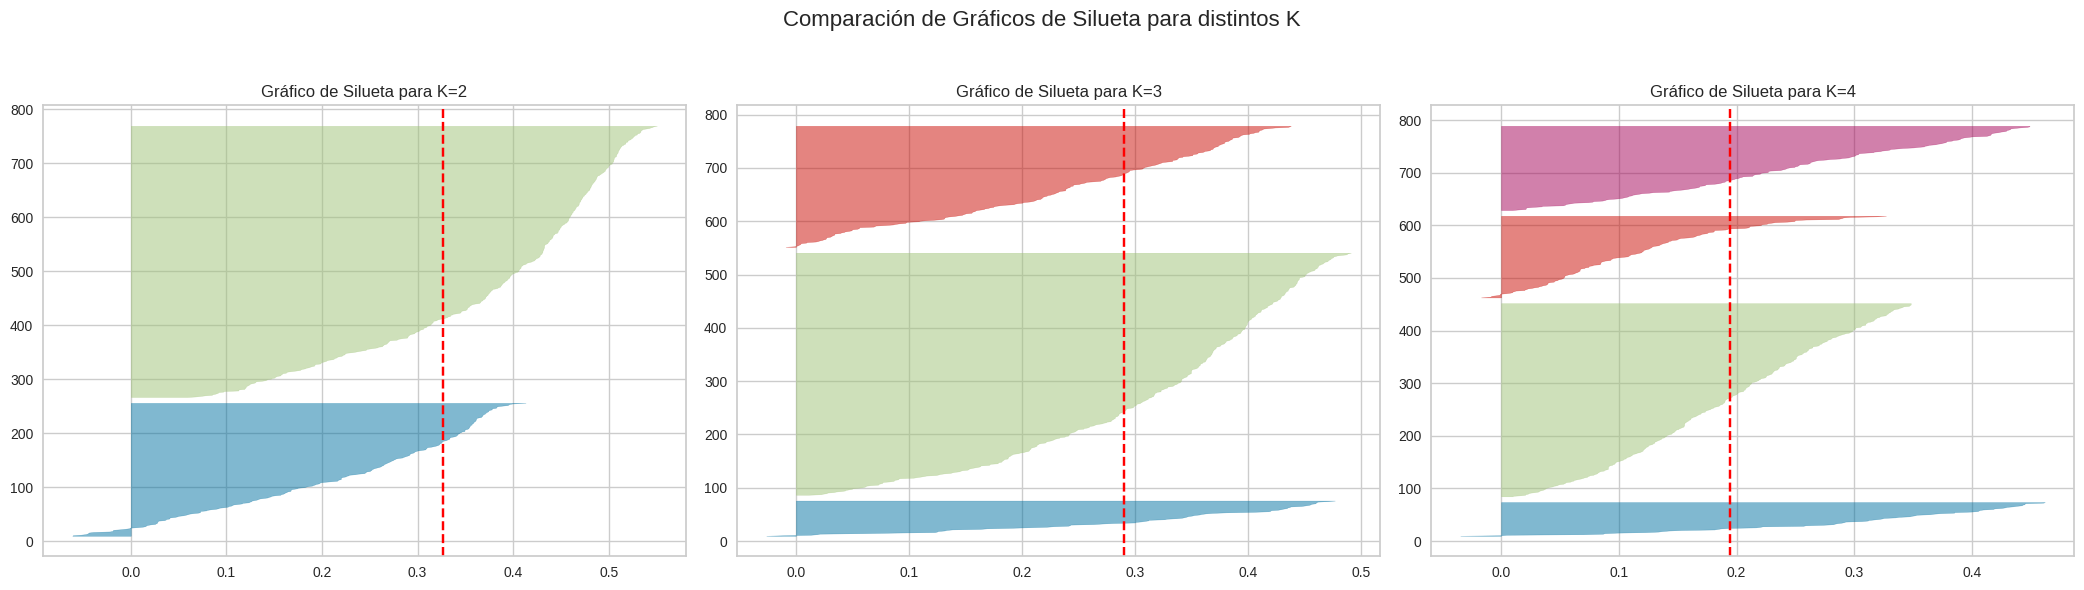

In [55]:
# Comparamos el gráfico de silueta para distintos K
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for i, k in enumerate([2, 3, 4]):
    ax = axes[i]

    model = KMeans(n_clusters=k, n_init='auto', random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax)
    visualizer.fit(data_scaled)

    ax.set_title(f'Gráfico de Silueta para K={k}')

    if i > 0:
        ax.set_ylabel('')

fig.suptitle('Comparación de Gráficos de Silueta para distintos K', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

La configuración con K=2 es la que presenta el puntaje de silueta promedio más alto.
Podemos interpretar que esta cantidad de clústeres es la más óptima para su separación y cohesión, siendo este el mismo resultado que nos dio el método del Codo.

### d) Realizar un análisis de cada grupo intentando entender en función de qué características fueron formados.

In [56]:
# Entreno el modelo

k_optimo = 2

kmeans_final = KMeans(n_clusters=k_optimo, n_init='auto', random_state=42)
kmeans_final.fit(data_scaled)

dump(kmeans_final, 'modelo_kmeans.joblib')

clusters = kmeans_final.fit_predict(data_scaled)

In [57]:
# Asigno el cluster correspondiente a cada track del dataset, y Calculo la media de cada variable en cada cluster, para comparar con la media general
ds['cluster'] = clusters

columnas_analisis = cuantitativas + ['cluster']
analisis_cuantitativo = ds[columnas_analisis].groupby('cluster').mean()

media_general = ds[cuantitativas].mean()
analisis_cuantitativo.loc['Media General'] = media_general

print("Medias de las Variables Cuantitativas:")
display(analisis_cuantitativo)



Medias de las Variables Cuantitativas:


,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature
cluster,,,,,,,,,,,
0,0.770730,0.485749,229355.526316,0.314417,0.226098,0.160219,-13.149567,0.065239,114.904842,0.374367,3.789474
1,0.154424,0.650793,215574.025845,0.731571,0.038444,0.224569,-6.230738,0.115528,123.107008,0.557699,3.958250
Media General,0.357394,0.596439,220112.733333,0.594188,0.100245,0.203376,-8.509339,0.098966,120.405761,0.497321,3.902667


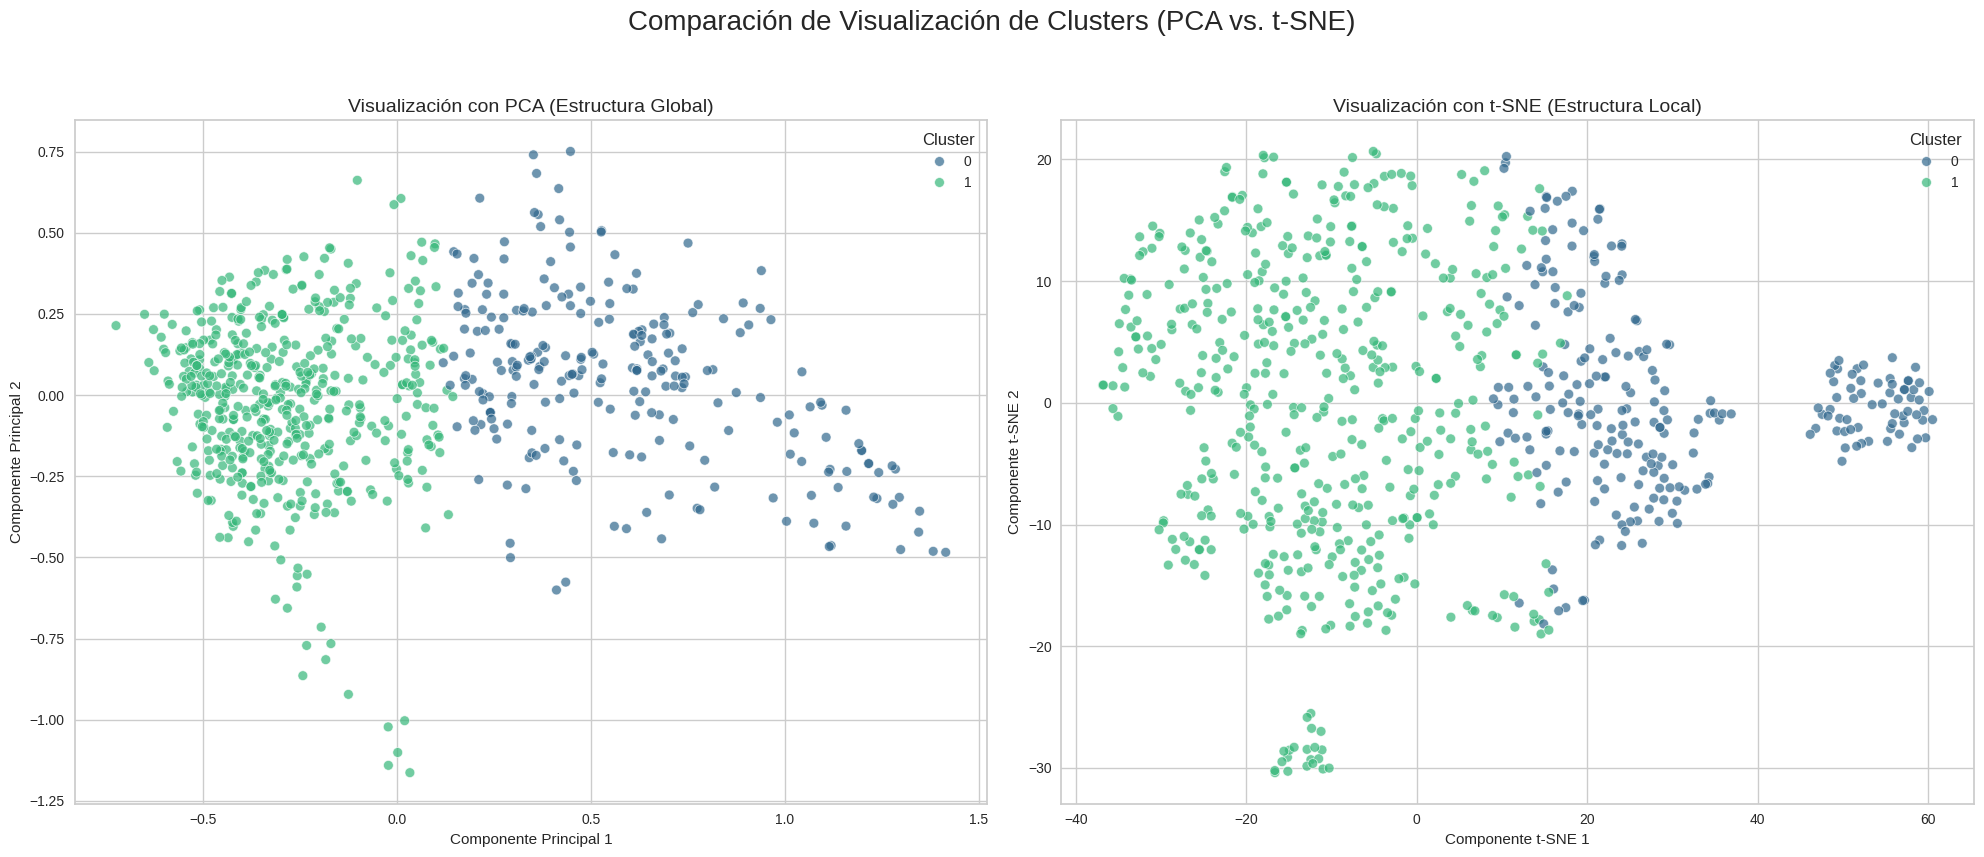

In [58]:

# 1. Reducción de Dimensionalidad

# a) PCA
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data_scaled)

# b) t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
data_tsne = tsne.fit_transform(data_scaled)


# 2. Gráficos Comparativos

fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Comparación de Visualización de Clusters (PCA vs. t-SNE)', fontsize=20)

# Gráfico de la izquierda: PCA
sns.scatterplot(
    ax=axes[0],
    x=data_pca[:, 0],
    y=data_pca[:, 1],
    hue=ds['cluster'],
    palette='viridis',
    s=50,
    alpha=0.7
)
axes[0].set_title('Visualización con PCA (Estructura Global)', fontsize=14)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].legend(title='Cluster')
axes[0].grid(True)

# Gráfico de la derecha: t-SNE
sns.scatterplot(
    ax=axes[1],
    x=data_tsne[:, 0],
    y=data_tsne[:, 1],
    hue=ds['cluster'],
    palette='viridis',
    s=50,
    alpha=0.7
)
axes[1].set_title('Visualización con t-SNE (Estructura Local)', fontsize=14)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].legend(title='Cluster')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Análisis de cada grupo

###### Cluster 0

Teniendo en cuenta que:

*   acousticness (0.77): Este valor es más del doble de la media general (0.35). Confirma que este cluster está fuertemente definido por su naturaleza acústica.
*   energy (0.31) y loudness (-13.14): Ambos están muy por debajo de la media general (0.59 y -8.50, respectivamente). Son canciones significativamente más suaves y con menos intensidad que la canción promedio.


* instrumentalness (0.22): También es más del doble de la media general (0.10), lo que indica una fuerte tendencia a ser música instrumental.

* valence (0.37): Está notablemente por debajo de la media (0.49), lo que refuerza un carácter más melancólico o serio, no alegre.

Podemos concluir que este cluster agrupa música mucho más acústica, tranquila e instrumental.

##### Cluster 1

Dado que:

* energy (0.73) y loudness (-6.23): Están muy por encima de la media general (0.59 y -8.50). Son canciones notablemente más potentes e intensas que el promedio.

* acousticness (0.15) e instrumentalness (0.03): Ambas están muy por debajo de la media general (0.35 y 0.10). Confirma que son pistas electrónicas/eléctricas y con una fuerte presencia vocal.

* danceability (0.65) y valence (0.55): Ligeramente por encima de la media (0.59 y 0.49), lo que las perfila como las canciones más optimistas y aptas para el baile del conjunto.

Este cluster contiene canciones más "mainstream" (energéticas, fuertes, y bailables), tieniendo un pronunciado contraste con el cluster 0.
